# **Stock Price Prediction Using Multiple Algorithms**
##Introduction:


*   Machine learning and deep learning have found their place in the financial institutions for their power in predicting time series data with high degrees of accuracy and the research is still going on to make the models better.



## Project workflow
The workflow for this project is essentially in these steps:

* Problem Understanding
* Linear Regression
* KNN Regression
* SVM Regression
* **RNN LSTM**
* Overall Conclusion

## Problem Understanding
### What are Stocks?
* Stock represents a claim on the company's assets and earnings. As you acquire more stock, your ownership stake in the company becomes greater.

### What is stock price prediction?
* Stock market prediction is the act of trying to determine the future value of a company stock or other financial instrument traded on an exchange. The successful prediction of a stock's future price could yield significant profit.
* Stock market analysis is divided into two parts:

  1. Fundamental analysis : involves analyzing a company’s financial statements to determine the fair value of the business
  2. Technical analysis : assumes that a security’s price already reflects all publicly-available information and instead focuses on the statistical analysis of price movements.

We will use dataset from Yahoo Finance's historical data of stocks.

[To know more about stocks, follow the link](https://www.investopedia.com/terms/s/stock.asp)

In [ ]:
!pip install yfinance
#import packages
import pandas as pd
import numpy as np
from datetime import datetime
from pandas_datareader import data as web
import yfinance as yf

#to plot the data
import matplotlib.pyplot as plt
plt.style.use('bmh')

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#fetching and storing the data in a dataframe
startingDate = '2013-01-01'
today = datetime.today().strftime('%Y-%m-%d')
df = pd.DataFrame()
# df = web.DataReader('AAPL', data_source = 'yahoo', start = startingDate, end = today)
appl = yf.Ticker('AAPL')
hist = appl.history(period="8y", auto_adjust=True)

df = hist

#print the head
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2013-08-07,14.527821,14.628057,14.464235,14.564783,298858000,0.000000,0.0
2013-08-08,14.625640,14.633208,14.439295,14.535779,255777200,0.108929,0.0
2013-08-09,14.461054,14.518440,14.303719,14.328942,266865200,0.000000,0.0
2013-08-12,14.404923,14.776663,14.397670,14.735991,364434000,0.000000,0.0
2013-08-13,14.848877,15.596776,14.757753,15.436287,881941200,0.000000,0.0


### **We notice that there are many variables in our dataset :**
* Open & Close : represents the starting and the final price of the stock in a day.
* Low & High & Last : represent the Low , High prices of the stock during the day & the last price of the share of the day.
* Total Trade Quantity : represent the number of shares sold.
* Turnover (Lacs) : represent the turnover of the company.

Let's Get the number of trading days, we have got using Quandl dataset.

In [ ]:
# Get the number of trading days
print(len(df))

2015


### Let's now plot the y variable (Close) to see how is the shape of it.

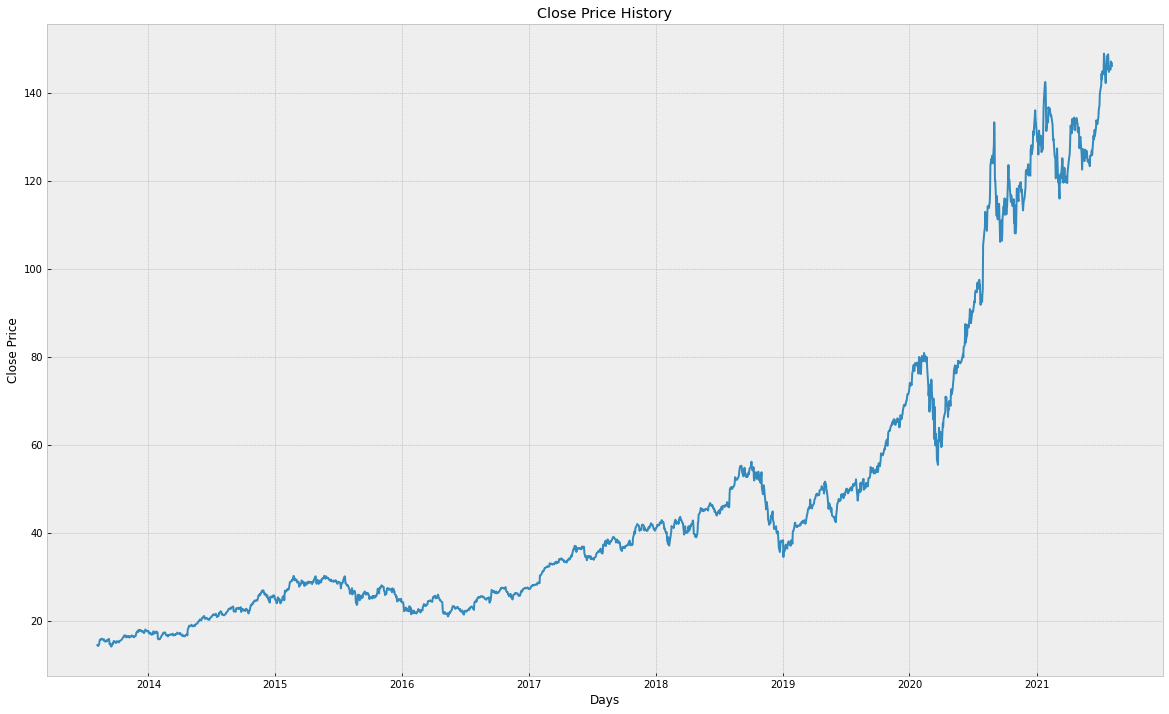

In [ ]:
# Visualise the close price data
plt.figure(figsize=(20, 12))
plt.title('Close Price History')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.plot(df['Close'])
plt.show()

### We will first sort the dataset in ascending order and then create a separate dataset so that any new feature created does not affect the original data.

In [ ]:
#setting index as date values
df['Date'] = pd.to_datetime(df.index.values, format = '%d-%m-%Y')
df.index = df['Date']

#sorting
data = df.sort_index(ascending=True, axis=0)
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date
Date,,,,,,,,
2013-08-07,14.527821,14.628057,14.464235,14.564783,298858000,0.000000,0.0,2013-08-07
2013-08-08,14.625640,14.633208,14.439295,14.535779,255777200,0.108929,0.0,2013-08-08
2013-08-09,14.461054,14.518440,14.303719,14.328942,266865200,0.000000,0.0,2013-08-09
2013-08-12,14.404923,14.776663,14.397670,14.735991,364434000,0.000000,0.0,2013-08-12
2013-08-13,14.848877,15.596776,14.757753,15.436287,881941200,0.000000,0.0,2013-08-13
...,...,...,...,...,...,...,...,...
2021-08-02,146.141047,146.730161,145.032707,145.302307,62880000,0.000000,0.0,2021-08-02
2021-08-03,145.591857,147.818517,144.962795,147.139542,64786600,0.000000,0.0,2021-08-03
2021-08-04,147.049692,147.568903,146.061168,146.730164,56368300,0.000000,0.0,2021-08-04


In [ ]:
#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

new_data.head()

,Date,Close
0,2013-08-07 00:00:00,14.5648
1,2013-08-08 00:00:00,14.5358
2,2013-08-09 00:00:00,14.3289
3,2013-08-12 00:00:00,14.736
4,2013-08-13 00:00:00,15.4363


In [ ]:
!pip install fastai

from fastai.tabular import  add_datepart
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp

new_data.head()

/usr/local/lib/python3.7/dist-packages/fastai/tabular/transform.py:63: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  for n in attr: df[prefix + n] = getattr(field.dt, n.lower())


,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,14.5648,2013,8,32,7,2,219,False,False,False,False,False,False
1,14.5358,2013,8,32,8,3,220,False,False,False,False,False,False
2,14.3289,2013,8,32,9,4,221,False,False,False,False,False,False
3,14.736,2013,8,33,12,0,224,False,False,False,False,False,False
4,15.4363,2013,8,33,13,1,225,False,False,False,False,False,False


* The add_datepart creates features based on the date variable.

* I have observed that the first and last day of the week affect the changement of stock's price more than normal days do!

* So let's create a new column which will contain the value 1 if its Monday or Friday and the value of 0 if not.

In [ ]:
new_data['mon/fri'] = 0
for i in range(0,len(new_data)):
    if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
        new_data['mon/fri'][i] = 1
    else:
        new_data['mon/fri'][i] = 0
new_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,mon/fri
0,14.5648,2013,8,32,7,2,219,False,False,False,False,False,False,0
1,14.5358,2013,8,32,8,3,220,False,False,False,False,False,False,0
2,14.3289,2013,8,32,9,4,221,False,False,False,False,False,False,1
3,14.736,2013,8,33,12,0,224,False,False,False,False,False,False,1
4,15.4363,2013,8,33,13,1,225,False,False,False,False,False,False,0


If the day of the week is equal to 0 or 4 , the mon_fri variable will set to 1 (True) other wise it will be set as a 0 (False).

## **Linear Regression**
### **Introduction:**
Let's start by the most basic algorithm that can be implimented on this usecase.

* Linear regression is a linear approach to modelling the relationship between a scalar response (or dependent variable) and one or more explanatory variables (or independent variables).

We will split the data into train and test set and then build our model.

* The Train set will be for training our model.
* The Test set will be for validation our model & Calculating its accuracy.

[Follow the link to undersatnd Linear Regression properly](https://towardsdatascience.com/linear-regression-detailed-view-ea73175f6e86)

In [ ]:
#split into train and validation/test
train = new_data[:int(len(new_data)/2)]
valid = new_data[int(len(new_data)/2):]

x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### **Results**
Let's now calculate the RMSE to check the accuracy of our model

In [ ]:
#make predictions and find the rmse
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
print(rms)

43.53969567293733


The RMSE (root mean square error) value is high, which clearly shows that linear regression has performed poorly and we can not count on this model.

### **Let’s look at the plot and understand why linear regression has not done well:**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


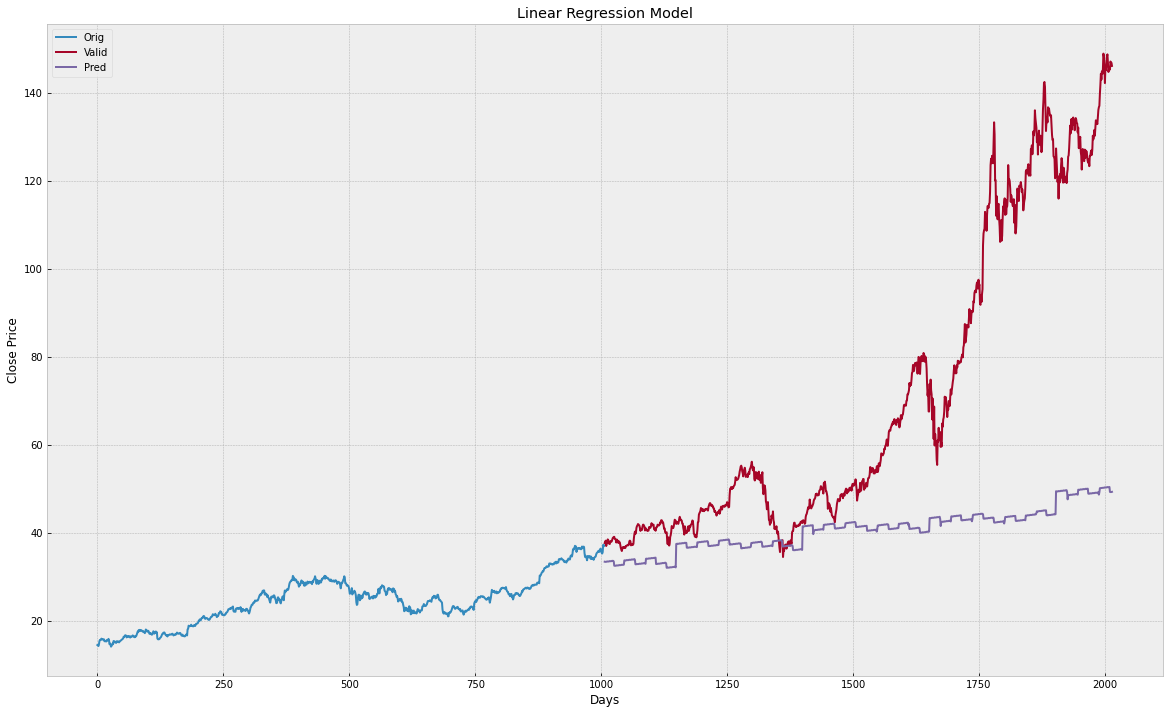

In [ ]:
# plot
valid['Predictions'] = preds

valid.index = new_data[int(len(new_data)/2):].index
train.index = new_data[:int(len(new_data)/2)].index

plt.figure(figsize=(20, 12))
plt.title('Linear Regression Model')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Orig', 'Valid', 'Pred'])
plt.show()

##**Conclusion**
It is a fact that Linear Regression is a simple algorithm that can be implemented quickly, but it has a few cons, which are affecting forecasting problems, since the model overfits the date column and not taking in consideration the last predicted point.

##**k-Nearest Neighbours Regression**
### **Introduction** :
Let's now dive in with another known algorithm

* The k-nearest neighbors algorithm (k-NN) is a non-parametric method used for classification and regression In both cases, the input consists of the k closest training examples in the feature space.

We will use the same dataset as earliear.

[Follow the link to understand KNN Regression Algo properly](https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/)



In [ ]:
# implement k-NN Regression
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()
model.fit(x_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

### **Results**
Let's now calculate the RMSE to check the accuracy of our model

In [ ]:
#make predictions and find the rmse
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
print(rms)

55.430410241983374


There is not a huge difference in the RMSE value as compared to Linear Regression.

### **Let's look at the plot of the predicted and actual values to get a more clear understanding.**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


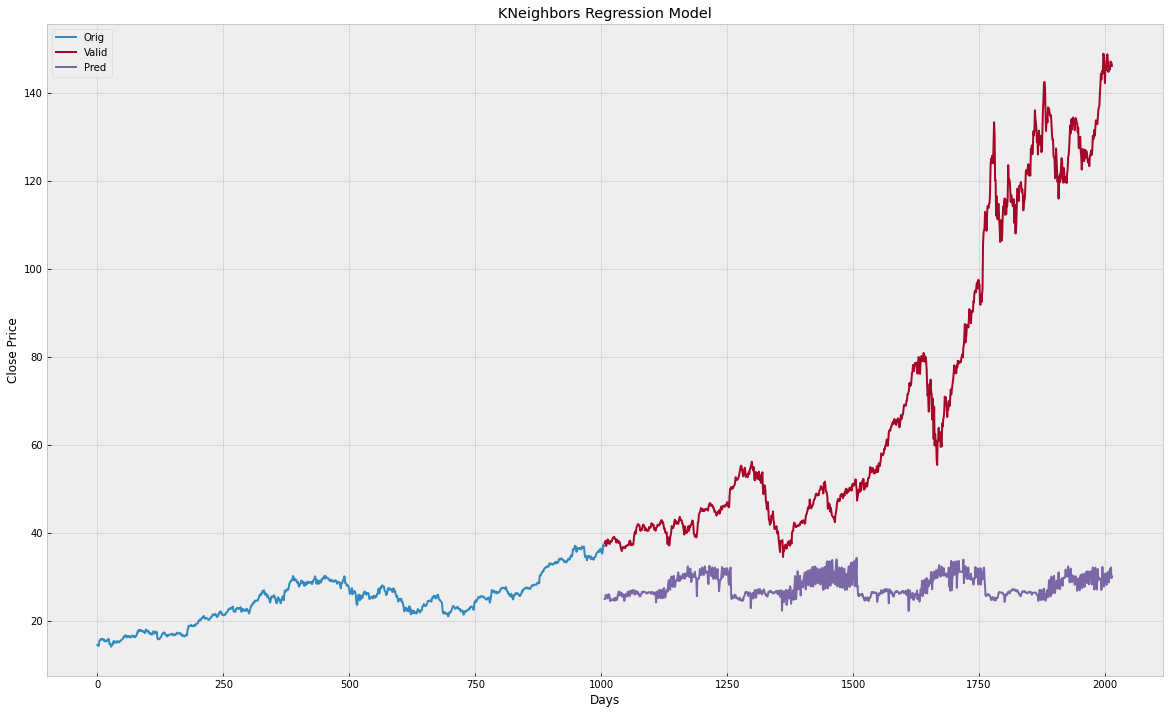

In [ ]:
# plot
valid['Predictions'] = preds

valid.index = new_data[int(len(new_data)/2):].index
train.index = new_data[:int(len(new_data)/2)].index

plt.figure(figsize=(20, 12))
plt.title('KNeighbors Regression Model')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Orig', 'Valid', 'Pred'])
plt.show()

### **Conclusion**
The KNN regression algorithm got us a close RMSE to the linear regression, it means it has also failed miserably.

## **Support Vector Regression**
### **Introduction:**
* Support Vector Regression is not a popular regression algorithm.

* To understand it properly, let's understand about SVM.

**Whis is SVM?**
* The objective of the *Support Vector Machine* algorithm is to find a 
hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.
* To separate the two classes of data points, there are many possible hyperplanes that could be chosen. Our objective is to find a plane that has the maximum margin, i.e the maximum distance between data points of both classes. Maximizing the margin distance provides some reinforcement so that future data points can be classified with more confidence.

#### **SVR acknowledges the presence of non-linearity in the data and provides a proficient prediction model.**

Same dataset will be used this time as well.

[Follow this link for better understanding of SVM](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47)


[Follow this link to undersatnd how SVR algorithm works](https://www.analyticsvidhya.com/blog/2020/03/support-vector-regression-tutorial-for-machine-learning/://)



In [ ]:
# implement Suppor Vector Regression
from sklearn.svm import SVR
model = SVR(kernel = 'rbf', C = 1e3, gamma = 0.1)
model.fit(x_train, y_train)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

### **Results**
Let's now calculate the RMSE to check the accuracy of our model

In [ ]:
#make predictions and find the rmse
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
print(rms)

57.64350314732185


Alas! To our disappointment, this algorithm can also not be used to predict future stock prices. 

### **Let's plot the real and predicted values.**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


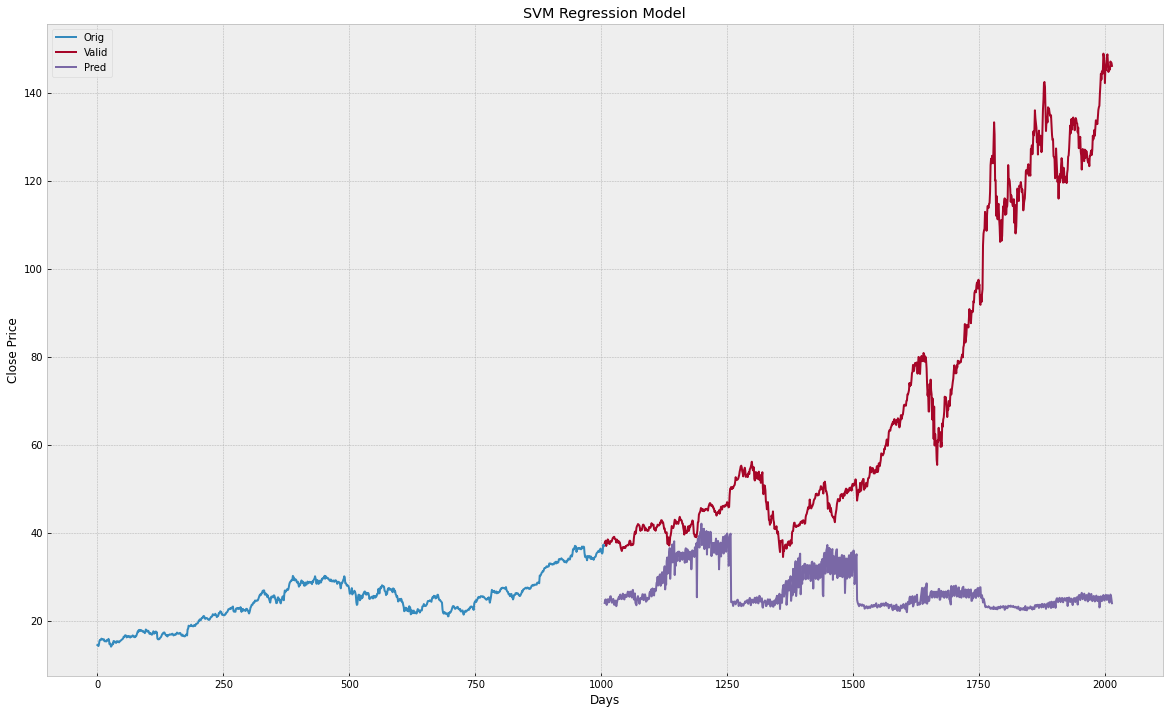

In [ ]:
# plot
valid['Predictions'] = preds

valid.index = new_data[int(len(new_data)/2):].index
train.index = new_data[:int(len(new_data)/2)].index

plt.figure(figsize=(20, 12))
plt.title('SVM Regression Model')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Orig', 'Valid', 'Pred'])
plt.show()

### **Conclusion**

So far we have used four (4) different regreesion models
1. Linear Regression
2. k-NN Regression
3. SVM Regression

to predict future stock prices, but all of them have failed miserably. 

**Therefore, we can conclude that the Regression Models can/should not be used to predict the future stock prices.**

#Long Short Term Memory (LSTM) - RNN
###**Introduction :**
As long as the regular machine learning algorithms doesnt go well with our data set, it means that we should change the direction to the aka DEEP LEARNING. We are having a timeseries based data set, so the first approach that comes in mind is RNN, particulary LSTM, because the model will be based on both past and present info.



*   Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies.
*   LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

LSTM has three gates:



1.   The input gate: The input gate adds information to the cell state
2.   The forget gate: It removes the information that is no longer required by the model
3.   The output gate: Output Gate at LSTM selects the information to be shown as output

###**Implementation :**

For now, let us implement LSTM and check it’s performance on our particular data.



In [ ]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[:int(len(new_data)/2),:]
valid = dataset[int(len(new_data)/2):,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
# x_train = scaler.fit_transform(x_train)

new_data.head()


,Close
Date,
2013-08-07,14.5648
2013-08-08,14.5358
2013-08-09,14.3289
2013-08-12,14.736
2013-08-13,15.4363


Now, the data is well prepared. 

Let's create the model

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
preds = model.predict(X_test)
preds = scaler.inverse_transform(preds)

print(model.summary())

947/947 - 43s - loss: 1.0032e-04
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
None


##**Result**

Let's now calculate the RMSE to check the accuracy of our model

In [ ]:
rms=np.sqrt(np.mean(np.power((valid-preds),2)))
print(rms)

3.8523221443494795


Amazing! The RMSE value for RNN is quite less. It signifies that the prediction has gone really well.

#**Let's plot the real and predicted values to have a better look:**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


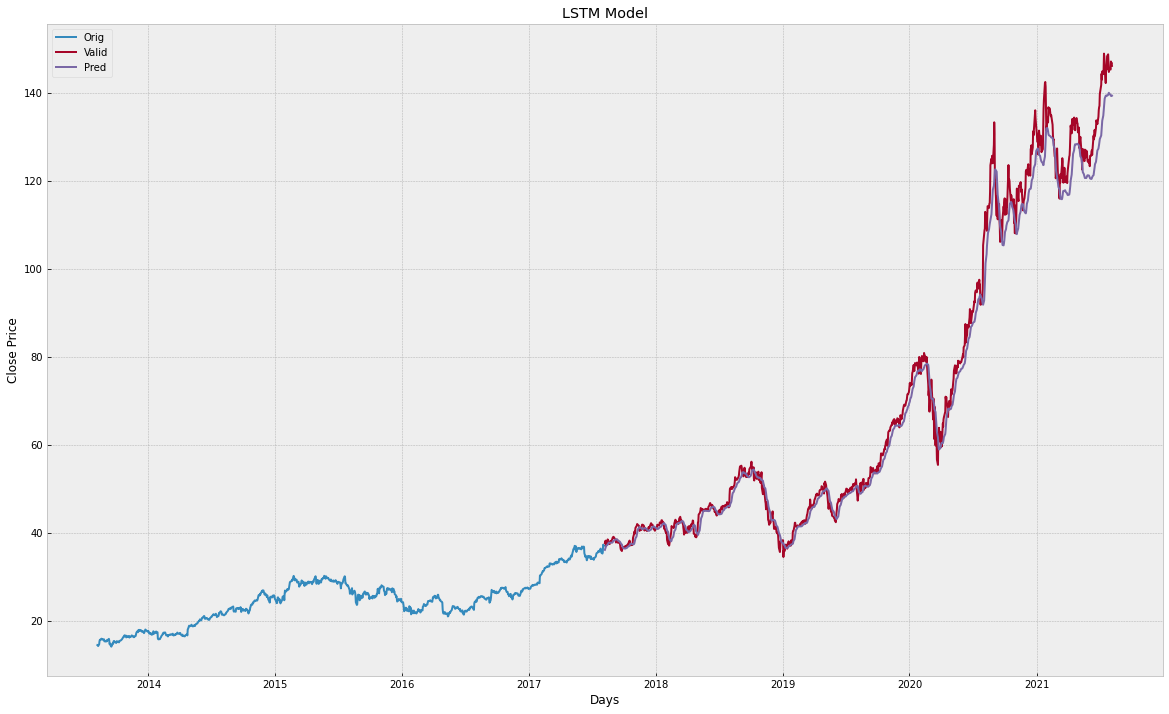

In [ ]:
# plot

valid = new_data[int(len(new_data)/2):]
train = new_data[:int(len(new_data)/2)]

valid['Predictions'] = preds

plt.figure(figsize=(20, 12))
plt.title('LSTM Model')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Orig', 'Valid', 'Pred'])
plt.show()

##**Conclusion**
Wow ! the results are really astonishing considering the usage only 1 epoch! LSTM can be called the MVP Algorithm so far when it comes to timeseries data. The Memory and fact that lstm is taking that in consideration when training the model shows its significance.

# **Overall Conclusion:**

Working with time series datasets is not that easy, since most of machine learning algorithms are not smart to detect the overfit on the Date column during the model training.

Thus, LSTM is a good choice to be used especially when dealing with this kind of problems.

## **Now, let's predict the price of AAPL stock after a year**

In [ ]:
# df = yf.download('AAPL', start=startingDate, end=today)[['Close']]

# x = []
# x.append(scaler.fit_transform(df.values)[-300:,0])
# x = np.array(x)
# x = scaler.fit_transform(x)

# trainpredict = scaler.inverse_transform(model.predict(x))

# print('Future Price : ' + str(trainpredict[256][0]) + ' $')

##**DecisionTree Regression**
### **Introduction** :
Let's now dive in with DecisionTree algorithm

* Decision Tree algorithm belongs to the family of supervised learning algorithms. Unlike other supervised learning algorithms, the decision tree algorithm can be used for solving regression and classification problems too.

* The goal of using a Decision Tree is to create a training model that can use to predict the class or value of the target variable by learning simple decision rules inferred from prior data(training data).

The same dataset will be used this time as well.

[Follow the link to understand more about Decision Trees](https://www.kdnuggets.com/2020/01/decision-tree-algorithm-explained.html#:~:text=Decision%20Tree%20algorithm%20belongs%20to%20the%20family%20of%20supervised%20learning%20algorithms.&text=The%20goal%20of%20using%20a,prior%20data(training%20data).)

[Follow the link to understand more about Decision Tree Regression Algorithm](https://towardsdatascience.com/machine-learning-basics-decision-tree-regression-1d73ea003fda)

In [ ]:
# implement Decision Tree Regression
# from sklearn.tree import DecisionTreeRegressor
# model = DecisionTreeRegressor()
# model.fit(x_train,y_train)

### **Results**
Let's now calculate the RMSE to check the accuracy of our model

In [ ]:
#make predictions and find the rmse
# preds = model.predict(x_valid)
# rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
# print(rms)

Using this algorithm, we are still getting similar (huge) RMSE values

### **Let's look at the plot of the predicted and actual values to get a more clear understanding.**

In [ ]:
# # plot
# valid['Predictions'] = preds

# valid.index = new_data[int(len(new_data)/2):].index
# train.index = new_data[:int(len(new_data)/2)].index

# plt.figure(figsize=(20, 12))
# plt.title('Decision Tree Regression Model')
# plt.xlabel('Days')
# plt.ylabel('Close Price')
# plt.plot(train['Close'])
# plt.plot(valid[['Close', 'Predictions']])
# plt.legend(['Orig', 'Valid', 'Pred'])
# plt.show()

### **Conclusion**
The Decision Tree Regression algorithm has also got us a very high RMSE. This isn't either a suitable algorithm to predict stock prices.


In [ ]:
# implement Polynomial Regression with degree 10
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.pipeline import make_pipeline

# degree = 9

# model = make_pipeline(PolynomialFeatures(degree),LinearRegression())
# model.fit(x_train, y_train)